In [87]:
packageVersion("ggplot2")
find.package("ggplot2")

[1] '3.5.1'

[1] "C:/Users/LiLi/AppData/Local/R/win-library/4.2/ggplot2"

In [88]:


install.packages("nnet")


Installation du package dans 'C:/Users/LiLi/AppData/Local/R/win-library/4.2'
(car 'lib' n'est pas spécifié)




  Une version binaire est disponible mais la version du source est plus
  récente:
     binary source needs_compilation
nnet 7.3-19 7.3-20              TRUE

  Binaries will be installed
le package 'nnet' a été décompressé et les sommes MD5 ont été vérifiées avec succés


Warning message:
"impossible de supprimer l'installation précédente du package 'nnet'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problème lors de la copie de C:\Users\LiLi\AppData\Local\R\win-library\4.2\00LOCK\nnet\libs\x64\nnet.dll vers C:\Users\LiLi\AppData\Local\R\win-library\4.2\nnet\libs\x64\nnet.dll: Permission denied"
Warning message:
"'nnet' restauré"



Les packages binaires téléchargés sont dans
	C:\Users\LiLi\AppData\Local\Temp\Rtmp2rgHf5\downloaded_packages


# R Experience Level:  Regression logistique, LDA, KNN, SVM

In [2]:
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)
library(repr)
library(recipes)
library(caret)
library(e1071)


Warning message:
"le package 'ggplot2' a été compilé avec la version R 4.2.3"
Warning message:
"le package 'tidyverse' a été compilé avec la version R 4.2.3"
Warning message:
"le package 'tibble' a été compilé avec la version R 4.2.3"
Warning message:
"le package 'readr' a été compilé avec la version R 4.2.3"
Warning message:
"le package 'dplyr' a été compilé avec la version R 4.2.3"
Warning message:
"le package 'forcats' a été compilé avec la version R 4.2.3"
Warning message:
"le package 'lubridate' a été compilé avec la version R 4.2.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.o

In [3]:
#library(nnet)
library(mlr3)
library(mlr3learners)
library(RColorBrewer)
library(e1071)
library(rpart)
#library(rpart.plot)

In [4]:
# fix random seed for reproducibility
set.seed(1234)

## GRAPH SETTINGS ##
# Save original parameters (optional)
original_par <- par(no.readonly = TRUE)

# Set global scaling factors (1.5x default size)
par(
  cex.lab = 1.5,   # Axis labels
  cex.axis = 1.5,  # Axis text (tick labels)
  cex.main = 1.5,  # Main title
  cex.sub = 1.5    # Subtitle
)

# Define a custom theme with larger fonts
custom_theme <- theme(
  text = element_text(size = 16),            # Global text size
  axis.title = element_text(size = 18),      # Axis labels
  axis.text = element_text(size = 14),       # Axis tick labels
  plot.title = element_text(size = 20),      # Main title
  plot.subtitle = element_text(size = 16)    # Subtitle
)

# Apply the theme to all future plots
theme_set(custom_theme)


## DATA LOADING & PROCESSING ##
# Load data
path <- "../../" # modifier le nombre de ../ si nécessaire
gym <- read.table(paste(path, "gym_members_exercise_tracking.csv", sep = ""),
                    sep = ",", header = TRUE)

gym[,'Gender'] <- as.factor(gym[,'Gender'])
gym[,'Workout_Type'] <- as.factor(gym[,'Workout_Type'])
gym[,'Experience_Level'] <- as.factor(gym[,'Experience_Level'])
gym[,'Workout_Frequency..days.week.'] <- as.factor(gym[,'Workout_Frequency..days.week.'])

gym[, "Weight..kg."] <- log(gym[,"Weight..kg."])

max_fat <- max(gym[,"Fat_Percentage"])
gym[, "Fat_Percentage"] <- sqrt((max_fat + 1) - gym[,"Fat_Percentage"])

# renome les variables Weight..kg. et BMI en LWeight et LBMI
names(gym)[names(gym) == "Weight..kg."] <- "LWeight"
names(gym)[names(gym) == "Fat_Percentage"] <- "SFat_Percentage"

gym <- gym %>% select(-c(BMI))

# divide data into training and testing sets for experience level
trainIndex <- createDataPartition(gym$Experience_Level, p = .8, 
                                  list = FALSE, 
                                  times = 1)
gym_train <- gym[ trainIndex,]
gym_test  <- gym[-trainIndex,]

# Normalize the data
gym_train_scaled = gym_train
scaler <- scale(gym_train[,-c(2,10,13,14)])

# Extract the center and scale attributes
center <- attr(scaler, "scaled:center")
scale <- attr(scaler, "scaled:scale")

gym_train_scaled[,-c(2,10,13,14)] <- scale(gym_train[,-c(2,10,13,14)], center = center, scale = scale)

gym_test_scaled = gym_test
gym_test_scaled[,-c(2,10,13,14)] <- scale(gym_test[,-c(2,10,13,14)], center = center, scale = scale)


cat("Data loaded and preprocessed")

Data loaded and preprocessed

In [5]:



## FUNCTION DEFINITIONS ##

# Function to plot residuals
# x: predicted values
# y: residuals
gplot.res <- function(x, y, titre = "titre"){
    ggplot(data.frame(x=x, y=y),aes(x,y))+
    geom_point(col = "blue")+#xlim(0, 250)+ylim(-155, 155)+
    ylab("Résidus")+ xlab("Valeurs prédites")+
    ggtitle(titre)+
    geom_hline(yintercept = 0,col="green")
}

# Function to plot ROC curve
# model: model to evaluate
# data: data to evaluate
# title: title of the plot
plot_roc <- function(model, data, title = "ROC curve"){
    pred <- predict(model, data, type = "response")
    roc <- roc(data$Experience_Level, pred)
    auc <- round(auc(roc), 2)
    plot(roc, main = title)
    text(0.8, 0.2, paste("AUC = ", auc), cex = 1.5)
}

#Fonction qui calcule et affiche le pourcentage d'erreur 
#à partirde la matrice de confusion

pourcentage_erreur <- function(conf_matrix) {
  total_samples <- sum(conf_matrix)
  errors <- total_samples - sum(diag(conf_matrix))
  error_percentage <- (errors / total_samples) * 100
  print(paste("Pourcentage d'erreur :", round(error_percentage, 2), "%"))
}

## Regression logistique (optimisation Lasso)

La régréssion logistque réalisée ici est multinomiale pour être adaptée à notre problème de clasification et prend en comte les interactions doubles. 
La fonction R glmnet calcule tous les modèles lasso (pénalisation L1, alpha=1 en argument) pour une séquence de 100 lambda puis évalue leurs performances par validation croisée. 

 Les données utilisés sont les donnnés "scalers" (moyenne à 0 ecart-type à 1) pour ne pas donner plus d'importance à certaines variables (glmnet fait des pénalisation avec les normes L1 (alpha=1)).

[1] "Temps d'exécution :  2.04294896125793"
[1] "Best Lambda : 0.000185359314211359"
[1] "LSE Lambda : 0.00438280135987971"


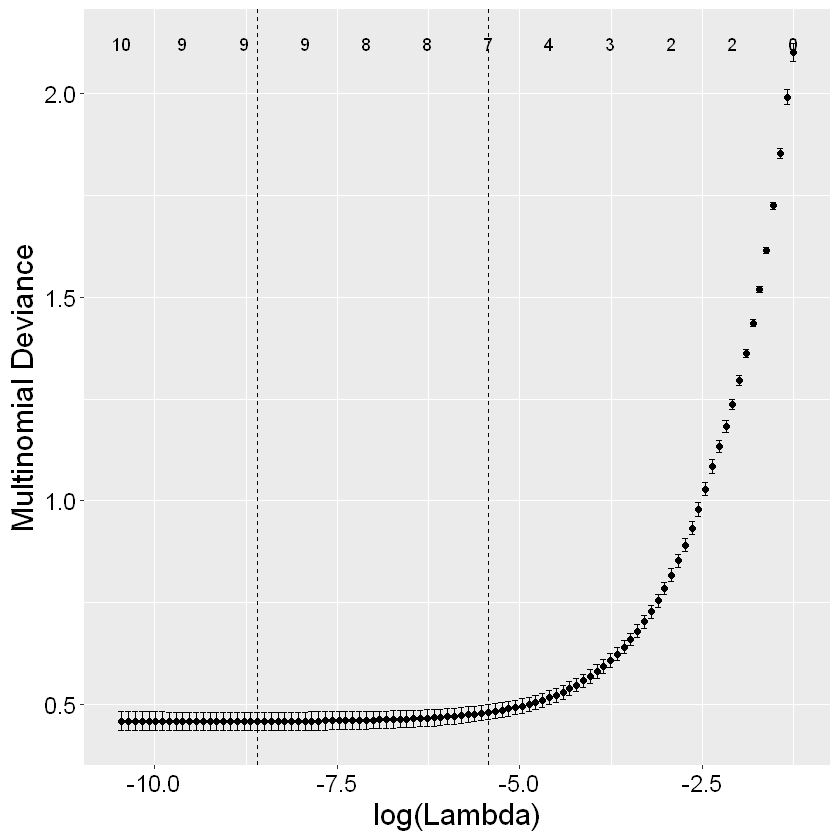

In [15]:
t0 <- Sys.time()

# Convertir les données en matrice pour glmnet
# si ~ .^2 => erreur = 15% environ
x <- model.matrix(Experience_Level ~ ., data = gym_train_scaled)[, -1] # Prédicteurs 
y <- model.matrix(~ Experience_Level + 0, data = gym_train_scaled)      # Réponse

# Ajustement du modèle avec validation croisée
cv_fit <- cv.glmnet(x, y, family = "multinomial", alpha = 1)
autoplot(cv_fit)

# Afficher le temps d'exécution
t <- Sys.time()
execution_time <- t - t0
print(paste("Temps d'exécution : ", execution_time))

# Afficher le meilleur lambda
best_lambda <- cv_fit$lambda.min
print(paste("Best Lambda :", best_lambda))

#Affiche le plus grand lambda envisageable
lse_lambda <- cv_fit$lambda.1se
print(paste("LSE Lambda :", lse_lambda))

- lambda petit= moins de pénalisation, modèle complexe avec beaucoup de variables non nulles 
- lambda grand= plus depénalisation, modèle simple avec bcp de coefs nulles
- courbe = performance sur validation croisée sauf forme erreur de prédiction

Interpetation: le plus grand lambda qui minimise la deviance est lambda min = 0.000295; et le plus grand lambda dont la déviance est à moins de u écart-type du minimum est LSE lambda= 0.0052791. On garde ce dernier qui fait un compromis entre la simplicité et la robustesse du modèle. 

Le choix du lamabda nous permet de réduire le nombre de coeffcients selectionnés.


In [7]:
# Choix du lambda
chosen_lambda <- lse_lambda

# Ajuster le modèle final avec le meilleur lambda
final_model <- glmnet(x, y, family = "multinomial", alpha = 1, lambda = chosen_lambda)

# Afficher les coefficients du modèle final
print(coef(final_model))

$Experience_Level1
18 x 1 sparse Matrix of class "dgCMatrix"
                                        s0
                                2.76270639
Age                             0.04454661
GenderMale                      .         
LWeight                         .         
Height..m.                      0.01526018
Max_BPM                         .         
Avg_BPM                         .         
Resting_BPM                     .         
Session_Duration..hours.       -1.15464048
Calories_Burned                -0.17927720
Workout_TypeHIIT                .         
Workout_TypeStrength            .         
Workout_TypeYoga                .         
SFat_Percentage                 .         
Water_Intake..liters.           .         
Workout_Frequency..days.week.3  .         
Workout_Frequency..days.week.4 -5.94077471
Workout_Frequency..days.week.5  .         

$Experience_Level2
18 x 1 sparse Matrix of class "dgCMatrix"
                                        s0
                 

In [12]:
# Extraire tous les coefficients
coefs_list <- coef(final_model)

# Pour chaque classe, compter les coefficients non nuls (hors intercept)
nombre_non_nuls_par_classe <- sapply(coefs_list, function(m) {
  sum(m[-1, ] != 0)  # Enlève intercept (-1) et compte les non-zéros
})

# Afficher
print(nombre_non_nuls_par_classe)

Experience_Level1 Experience_Level2 Experience_Level3 
                5                 7                 4 


La methode Lasso avec le lambda 1se permet de garder uniquement 5 coefficients pour la classe Experience_Level1, 7 pour Experience_Level2 et 4 pour Experience_Level3, contre 17 par classe à l'origine. 

On affiche la matrice de confusion associée à ce modèle. 

In [95]:
#matrice de confusion 

# Convertir les données test en matrice pour glmnet de la meme manière 
#que pour les données d'apprentissage 
# si ~ .^2 => erreur = 15% environ
x_test <- model.matrix(Experience_Level ~ ., data = gym_test_scaled)[, -1]  # Prédicteurs
y_test <- model.matrix(~ Experience_Level + 0, data = gym_test_scaled)  # Réponse réelle (one-hot)

# Prédiction des probabilités pour chaque classe
pred_probs <- predict(final_model, newx = x_test, type = "response") 

# Modification nécessaires pour tracer les courbes ROC 
probabilities_logit <- pred_probs[,,1]
probabilities_logit <- as.data.frame(probabilities_logit)
colnames(probabilities_logit) <- c("1", "2", "3")


# Convertir les probabilités en classes prédictes (classe avec proba max)
pred_class <- apply(pred_probs, 1, which.max)
# Convertir y_test en indices de classes réelles
true_class <- apply(y_test, 1, which.max)

# Construire la matrice de confusion
conf_matrix_logit <- table(Predicted = pred_class, Actual = true_class)
print(conf_matrix_logit)
pourcentage_erreur(conf_matrix_logit)

         Actual
Predicted  1  2  3
        1 67 19  0
        2  8 62  0
        3  0  0 38
[1] "Pourcentage d'erreur : 13.92 %"


On voit qu'il y a eu des erreures de prédiction pour 28 persones, et ces erreures sont toujours entre les niveau d'expérience 1 et deux. Le pourcentage d'erreure de prédiction est de 14.43%, assez élevé. 

#### Courbe ROC

In [97]:
plot_roc_multiclass <- function(probabilities, true_labels, title = "ROC Curve") {
  # One-vs-all ROC pour chaque classe
  classes <- colnames(probabilities)
  colors <- c("red", "blue", "green") # Une couleur par classe
  
  # Nouveau plot vide
  plot(0, 0, type = "n", xlim = c(1,0), ylim = c(0,1),
       xlab = "Spécificité", ylab = "Sensibilité", main = title)
  
  for (i in seq_along(classes)) {
    roc_obj <- roc(as.numeric(true_labels == classes[i]), probabilities[[i]])
    lines(1 - roc_obj$specificities, roc_obj$sensitivities, col = colors[i], lwd = 2)
    
    auc_val <- round(auc(roc_obj), 2)
    text(0.7, 0.3 - 0.07*i, paste("Classe", classes[i], "AUC =", auc_val), col = colors[i], cex = 1.2)
  }
  
  abline(a = 0, b = 1, lty = 2) # Diagonale random
}

Setting levels: control = 0, case = 1



ERROR: Error in roc.default(as.numeric(true_labels == classes[i]), probabilities[[i]]): Response and predictor must be vectors of the same length.


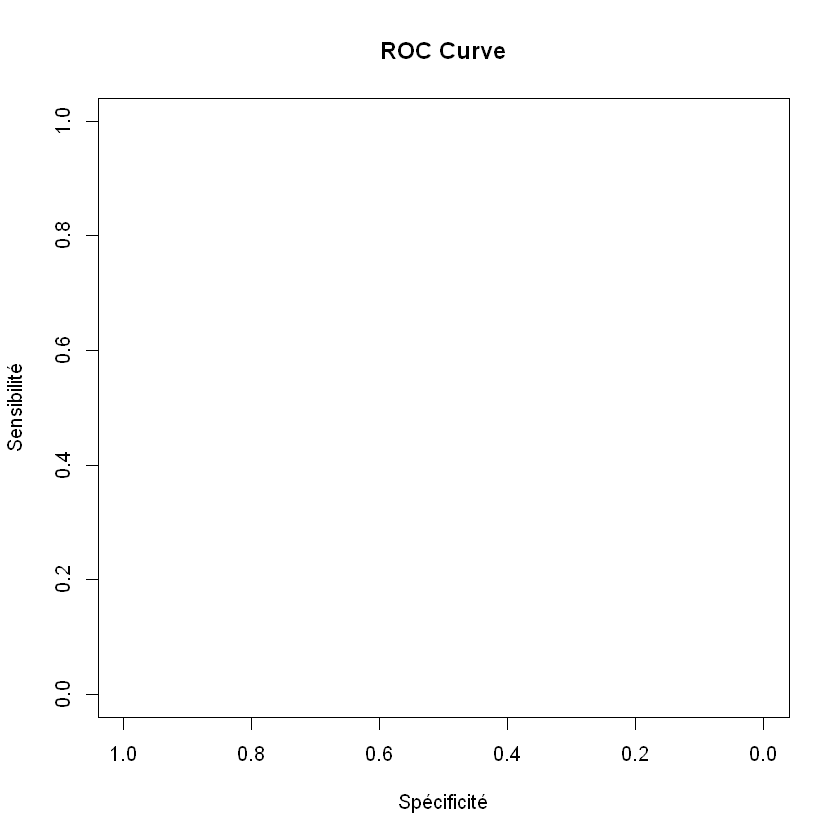

In [99]:
plot_roc_multiclass(probabilities_logit, y_test)

### Analyse Discriminante Linéaire LDA

In [13]:
# Initialisation de la validation croisée avec 10 folds
# Intervient dès que l'on utilise la
# fonction train du package caret
param_train<-trainControl(method="cv",number=10)

In [16]:
t0 <- Sys.time()

lda.fit<-train(Experience_Level ~ ., data = gym_train_scaled, method="lda")

# erreur par validation croisée  en analyse discriminante linéaire
lda.fit <- train(Experience_Level ~ ., data = gym_train_scaled, method="lda",trControl=param_train)

predictions_lda <-predict(lda.fit, gym_test_scaled)
probabilities_lda <-predict(lda.fit, gym_test_scaled, type="prob")

# Afficher le temps d'exécution
t <- Sys.time()
execution_time <- t - t0
print(paste("Temps d'exécution : ", execution_time))

# estimer le taux d'erreur à partir de la matrice de confusion
conf_matrix_lda=table(gym_test_scaled[,"Experience_Level"],predictions_lda)
print(conf_matrix_lda)
pourcentage_erreur(conf_matrix_lda)



[1] "Temps d'exécution :  1.10321998596191"
   predictions_lda
     1  2  3
  1 64 11  0
  2 17 64  0
  3  0  0 38
[1] "Pourcentage d'erreur : 14.43 %"


Le pourcentage d'erreur est très proche de celui obtenus avec la regression logistque optimisée par Lasso. Les erreurs sont à nouveau entre les niveaux d'expérience 1 et 2, cette fois il y a plus d'individus prédits du nuveau 2 alors qu'il sont du niveau 1.

mettre courbe ROC 

### k-Nearest Neighbour Classification kNN 

In [17]:
#knn.fit<-train(Experience_Level ~ ., data = gym_train_scaled ,method="knn")

t0 <- Sys.time() 

# erreur par validation croisée  en kNN
knn.fit <- train(Experience_Level ~ ., data = gym_train_scaled, method="knn",trControl=param_train,tuneLength=20)

predictions_knn <-predict(knn.fit, gym_test_scaled)
probabilities_knn <-predict(knn.fit, gym_test_scaled, type="prob")

# Afficher le temps d'exécution
t <- Sys.time()
execution_time <- t - t0
print(paste("Temps d'exécution : ", execution_time))

# estimer le taux d'erreur à partir de la matrice de confusion
conf_matrix_knn=table(gym_test_scaled[,"Experience_Level"],predictions_knn)
print(conf_matrix_knn)
pourcentage_erreur(conf_matrix_knn)

[1] "Temps d'exécution :  1.94258213043213"
   predictions_knn
     1  2  3
  1 43 32  0
  2 17 64  0
  3  0  0 38
[1] "Pourcentage d'erreur : 25.26 %"


Le pourcentage d'erreur de prédiction est beaucoup pluss élevé que pour les deux derniers modèle. Le modèle de prédiction par KNN n'est pas "rouste", la prédiction est mauvaise. On retrouve que les niveau d'expérience 1 et deux sont souvent mélangés. 

### SVM kernel radial 

[1] "Temps d'exécution :  32.3715310096741"


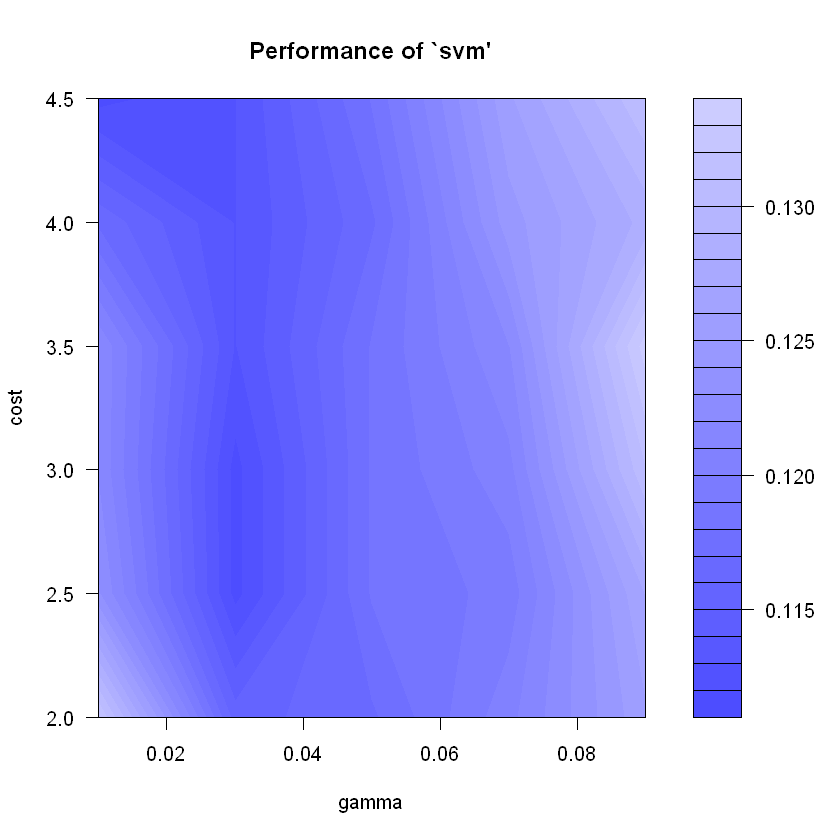

In [18]:
t0 <- Sys.time()

#La zone de recherche est volontairement déjà centré sur les paramètres optimaux
svm.rad.tune = tune.svm(Experience_Level ~ ., data = gym_train_scaled, cost = c(2, 2.5, 3, 3.5,4,4.5), 
    gamma = seq(0.01, 0.1, by = 0.02), kernel= "radial")
plot(svm.rad.tune)

# Afficher le temps d'exécution
t <- Sys.time()
execution_time <- t - t0
print(paste("Temps d'exécution : ", execution_time))

temps d'execution long (30s)

In [ ]:
svm.rad = svm(Experience_Level ~ ., data = gym_train_scaled, 
              cost = svm.rad.tune$best.parameters$cost, 
              gamma = svm.rad.tune$best.parameters$gamma,
              probability=TRUE)

pred.svm.rad=predict(svm.rad,newdata=gym_test_scaled,probability=TRUE)

#Utiles pour les courbes ROC :
probabilities_svm.rad <- attr(pred.svm.rad, "probabilities")
probabilities_svm.rad <- as.data.frame(probabilities_svm.rad)

conf_matrix_svm.rad=table(gym_test_scaled[,"Experience_Level"],pred.svm.rad)
print(conf_matrix_svm.rad)
pourcentage_erreur(conf_matrix_svm.rad)

   pred.svm.rad
     1  2  3
  1 63 12  0
  2 17 64  0
  3  0  0 38
[1] "Pourcentage d'erreur : 14.95 %"


Semblable logit et analyse discriminante: erreur de prédiction 0.1495. Toujour entre niv 1 et 2.

### SVM kernel polynomial

[1] "Temps d'exécution :  10.4820718765259"


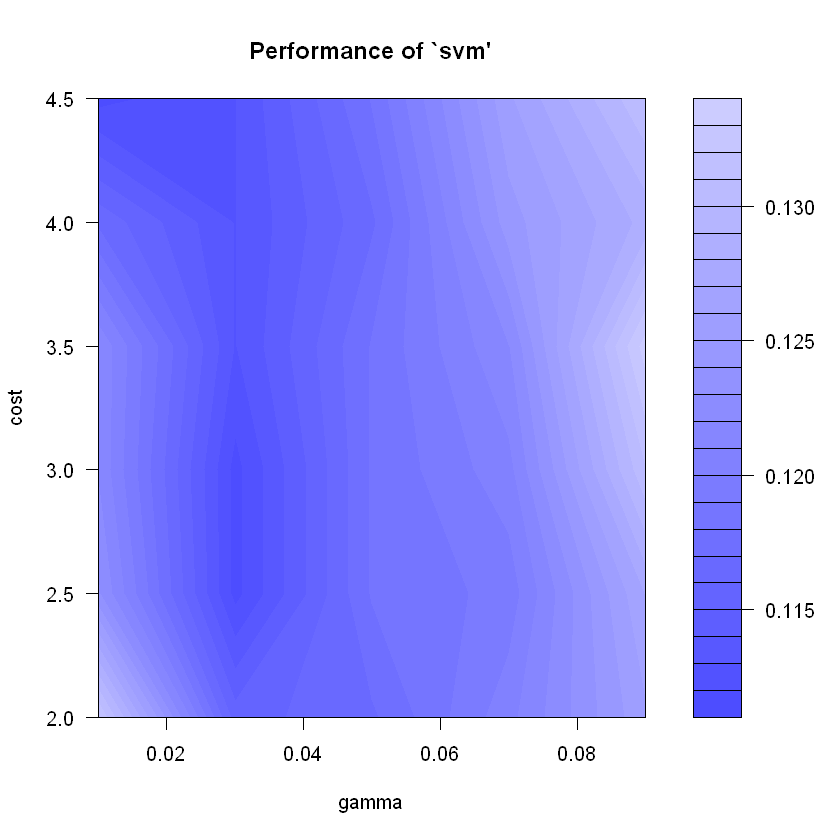

In [19]:
# On peut rajouter :
# coef0 = c(0.5,1,1.5), degree= c(2,3)
# Mais c'est trop long

t0 <- Sys.time()

svm.pol.tune = tune.svm(Experience_Level ~ ., data = gym_train_scaled, kernel= "polynomial", cost = c(3.5,4,4.5,5), 
    gamma = seq(0.01, 0.1, by = 0.02), coef0=1, degree=3) 

plot(svm.rad.tune)

# Afficher le temps d'exécution
t <- Sys.time()
execution_time <- t - t0
print(paste("Temps d'exécution : ", execution_time))

temps d'execution plus raisonnable (11s), quand on ajoute l'optimisationd de cef0 et degree trop long. 

In [ ]:
svm.pol = svm(Experience_Level ~ ., data = gym_train_scaled, kernel= "polynomial",
              cost = svm.pol.tune$best.parameters$cost, 
              gamma = svm.pol.tune$best.parameters$gamma,
              coef0 = 1,
              degree = 3,
              probability=TRUE)

pred.svm.pol=predict(svm.pol,newdata=gym_test_scaled,probability=TRUE)

#Utiles pour les courbes ROC :
probabilities_svm.pol <- attr(pred.svm.pol, "probabilities")
probabilities_svm.pol <- as.data.frame(probabilities_svm.pol)

conf_matrix_svm.pol=table(gym_test_scaled[,"Experience_Level"],pred.svm.pol)
print(conf_matrix_svm.pol)
pourcentage_erreur(conf_matrix_svm.pol)

   pred.svm.pol
     1  2  3
  1 64 11  0
  2 17 64  0
  3  0  0 38
[1] "Pourcentage d'erreur : 14.43 %"


Pas d'amélioration par rapport au kernel radial 

courbe roc: 